# Stock market growth indicators

<img style="float:none; position: relative; " src="17086570218_70271813b1_w.jpg"> 

<div style="text-align:center; font-size:70%;"> Photo by Sam Valadi, source Flickr.com   <a href="https://www.flickr.com/photos/132084522@N05/17086570218/">(Link)</a></div> 
    
In these notes we compare some long term investing strategies in the stock market, e.g., in stocks or ETFs. In our setting we have 1 cash unit each month at our disposal for investment. We consider three strategies:



<ol>
<li>Bollinger+: We invest all our cash reserve if the values are above a given Bollinger band, otherwise we wait.</li>
<li>Bollinger+Min: Same as above but with the additional restriction for investment that the change of the moving average is close to 0 (we are close to local extreme values).</li>
<li>Sparplan: We invest 1 cash unit on the first weekday of every month.</li>
</ol>
Also, in all of these strategies we never sell. In this comparison we disregard transaction costs. The comparison is done in terms of some examples in recent times.


## Description of data: 
The data is fetched from finance.yahoo.com. The index set are dates from 01.01.2000 to today (only weekdays). 

The columns contain the following information: 
<ul>
<li>"High" = highest daily value </li>
<li>"Low" = lowest daily value. </li>
<li> "Open" = opening daily value. </li>
<li>"Close" = closing daily value. </li>
<li> "Volume" = traded volume. </li>
<li> "Adj Close" = adjusted closing value. </li>
</ul> 
The value corresponds to the price of a certain stock or to points of an index.

## Features used in our strategies:
<ul>
<li>Moving averages: average of the value in the last N days.</li>
<li>Bollinger band: interval (moving average-K*standard deviation,moving average+K*standard deviation).</li>
</ul>

N and K are parameters that we will try to optimize based on historical data for the given stock or index.

## Outline:

1. [Preprocessing](#prepro)<br>
2. [Indicators](#indi)<br>
3. [Scores](#scores)<br>
4. [Strategies](#strat) <br>
5. [Parameter tuning](#tuning)<br>
6. [Evaluation of results](#eval)<br>


### Disclaimer:
This is not a suggestion, recommendation or order for trading. These numbers are only indicators that may be incorrect. 

## 1. Preprocessing <a id="prepro"></a>

In this section we load the data, visualize it and compute some useful new features:

<ul>
<li>"Daily" = ("High" + "Low") / 2 </li>
<li>"Ma" = moving average in the last N days (N is a parameter) </li>
<li> "Std" = standard deviation considering the last N days </li>
<li>"BollingerLow" = "Ma" - K * Std (lower Bollinger bound, K is a parameter) </li>
<li>  "BollingerHigh" = "Ma" + K * Std (upper Bollinger bound) </li>
<li> "Growth" = difference of moving average compared to previous day </li>
<li> "GrowthSum" = sum of "Growth" in the previous M days (M is a parameter) </li>
</ul> 

We have 3 parameters that will be used for optimization: N, K and M.

In [185]:
# Import libraries.
import pandas as pd
import pandas_datareader.data as dr
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from itertools import product

In [186]:
# Loading an index/stock from finance.yahoo.com.
# For other indices/stocks, just change the corresponding symbol, 
#see, e.g., https://finance.yahoo.com/world-indices/

symb = '^GDAXI' # Symbol. 
name = "DAX"    # Name - change accordingly.
start = dt.datetime(2000,1,1)
end = dt.date.today()
df = dr.DataReader(symb,'yahoo', start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,7159.330078,6720.870117,6961.720215,6750.759766,43072500.0,6750.759766
2000-01-04,6755.359863,6510.459961,6747.240234,6586.950195,46678400.0,6586.950195
2000-01-05,6585.850098,6388.910156,6585.850098,6502.069824,52682800.0,6502.069824
2000-01-06,6539.310059,6402.629883,6501.450195,6474.919922,41180600.0,6474.919922
2000-01-07,6791.529785,6470.140137,6489.939941,6780.959961,56058900.0,6780.959961


<AxesSubplot:title={'center':'DAX 2019-today'}, xlabel='Date'>

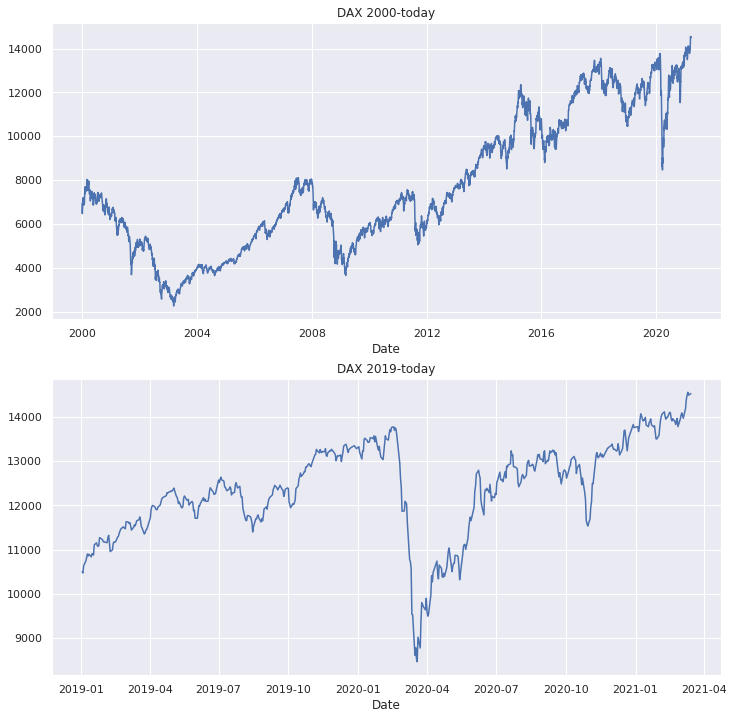

In [187]:
#Visualization of daily average (we define daily average as the average of highest and lowest value).
daily = (df.High + df.Low) / 2
fig, ax = plt.subplots(2,1,figsize=(12,12))
ax[0].set_title(name + " 2000-today")
sns.lineplot(data=daily, ax=ax[0])
daily_2019 = daily.loc["2019-01-01":]
ax[1].set_title(name + " 2019-today")
sns.lineplot(data=daily_2019, ax=ax[1])

In [188]:
# Computation of average daily value and dropping everything else.
class DailyClean(BaseEstimator, TransformerMixin):
    def fit(self, DF):
        self.d = (DF.High + DF.Low) / 2
        return self
    def transform(self, DF):
        return pd.DataFrame(self.d, columns=["Daily"])
    
# Computation of new features.
class MaStd(BaseEstimator, TransformerMixin):
    def __init__(self, N=20, K=2, M=10): 
        self.N = N
        self.K = K
        self.M = M
    def fit(self, DF):
        return self
    def transform(self, DF):
#         print("Parameters N={}, K={}, M={}".format(self.N, self.K, self.M))
        DF_new = DF.copy()
        DF_new["Ma"] = DF.Daily.rolling(window=self.N, min_periods=1).mean() #Moving average in last N days.
        DF_new["Std"] = DF.Daily.rolling(window=self.N, min_periods=1).std() #Standard deviation in last N days.
        DF_new["BollingerLow"] = DF_new.Ma - self.K * DF_new.Std  #Lower Bollinger bound.
        DF_new["BollingerHigh"] = DF_new.Ma + self.K * DF_new.Std   #Upper Bollinger bound.
        trend = np.zeros(len(DF))
        for i in range(1, len(DF)):
            trend[i] = DF_new.iloc[i,1] - DF_new.iloc[i-1,1]
        DF_new["Growth"] = trend  #Daily growth of moving average.
        DF_new["GrowthSum"] = DF_new.Growth.rolling(window=self.M, min_periods=1).sum() #Sum growth in last M days.
        DF_new.dropna(axis=0, how='any', inplace=True) #Drop first row and anything if missing data.
        return DF_new    

In [189]:
# New features.
pipe = Pipeline([("daily_clean", DailyClean()), ("mean_std", MaStd(N=20, K=1.5, M=10))])
df_new = pipe.fit_transform(df)
df_new.head()

,Daily,Ma,Std,BollingerLow,BollingerHigh,Growth,GrowthSum
Date,,,,,,,
2000-01-04,6632.909912,6786.505005,217.216263,6460.680610,7112.329400,-153.595093,-153.595093
2000-01-05,6487.380127,6686.796712,231.120495,6340.115969,7033.477455,-99.708293,-253.303385
2000-01-06,6470.969971,6632.840027,217.385413,6306.761907,6958.918147,-53.956685,-307.260071
2000-01-07,6630.834961,6632.439014,188.263426,6350.043875,6914.834152,-0.401013,-307.661084
2000-01-10,6880.364990,6673.760010,196.466390,6379.060425,6968.459594,41.320996,-266.340088


<AxesSubplot:title={'center':'DAX 2019-today'}, xlabel='Date'>

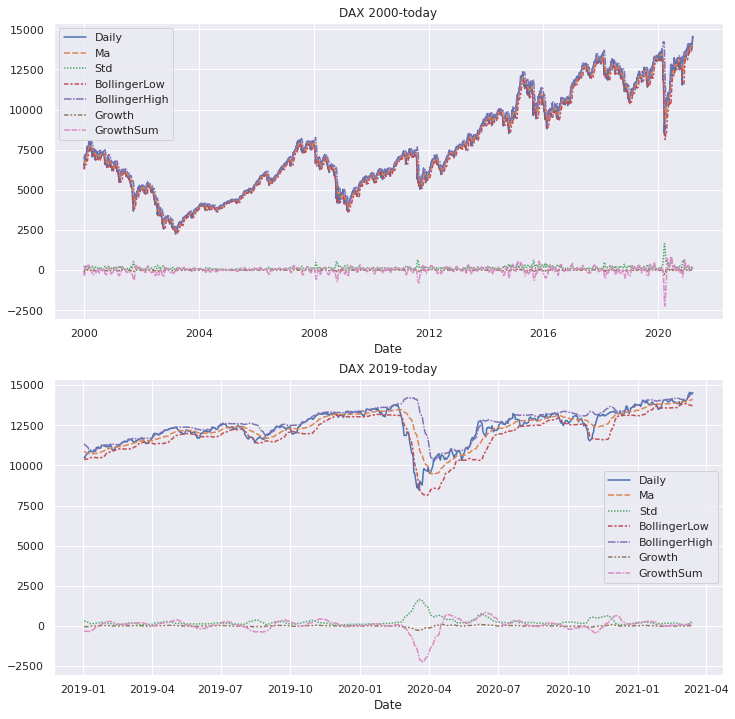

In [190]:
# Visualization of new features.
fig, ax = plt.subplots(2,1,figsize=(12,12))
ax[0].set_title(name + " 2000-today")
sns.lineplot(data=df_new, ax=ax[0])
df_new_2019 = df_new.loc["2019-01-01":, :]
ax[1].set_title(name + " 2019-today")
sns.lineplot(data=df_new_2019, ax=ax[1])

## 2. Indicators <a id="indi"></a>

<ul>
<li>Daily value is above Bollinger band. </li>
<li>GrowthSum is close to 0 (this means that we are close to a local minimum or maximum.). </li>
</ul>
To quantify the distance to 0 in the last criterium we introduce a parameter eps.

### Daily value is above Bollinger band.

In [191]:
# Value is higher than upper Bollinger bound.
class BollUp(BaseEstimator, TransformerMixin): 
    def fit(self, DF):
        return self
    def transform(self, DF): 
        return DF[DF["Daily"]>= DF["BollingerHigh"]]
bollup = BollUp()
B = bollup.fit_transform(df_new_2019)

<AxesSubplot:title={'center':'Daily value above Bollinger band'}, xlabel='Date', ylabel='BollingerLow'>

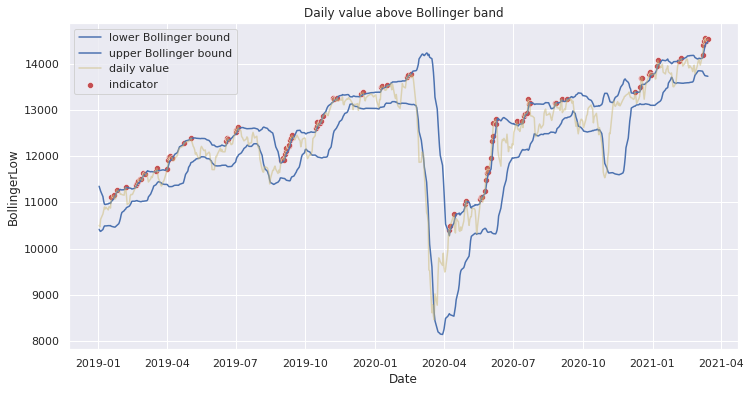

In [192]:
# Visualization of this indicator.
fig, ax = plt.subplots(1,1,figsize=(12,6))
plt.title("Daily value above Bollinger band")
sns.lineplot(data = df_new_2019.BollingerLow, ax=ax, color="b", label = 'lower Bollinger bound')
sns.lineplot(data = df_new_2019.BollingerHigh, ax=ax, color="b", label = 'upper Bollinger bound')
sns.lineplot(data = df_new_2019.Daily,alpha=0.5, ax=ax, color="y", label = 'daily value')
sns.scatterplot(data = B.Daily, color="r", ax=ax, label = 'indicator')

This is a good indicator of growth, however, we have indicators close to local maximums, that should be avoided.

### Growth is close to 0
In fact, we consider the points where the sum of the growth in the last M days is in the interval (-eps, eps). eps is a parameter. 

In [193]:
#GrowthSum is in the interval (-eps, eps) 
class LocalE(BaseEstimator, TransformerMixin):
    def __init__(self, eps=100): 
        self.eps = eps
    def fit(self, DF):
        return self
    def transform(self,DF):
        return DF[(DF["GrowthSum"]>=-self.eps) & (DF["GrowthSum"]<=self.eps)]
local = LocalE()
B = local.fit_transform(df_new_2019)

<AxesSubplot:title={'center':'Averaged growth is close to 0'}, xlabel='Date', ylabel='Ma'>

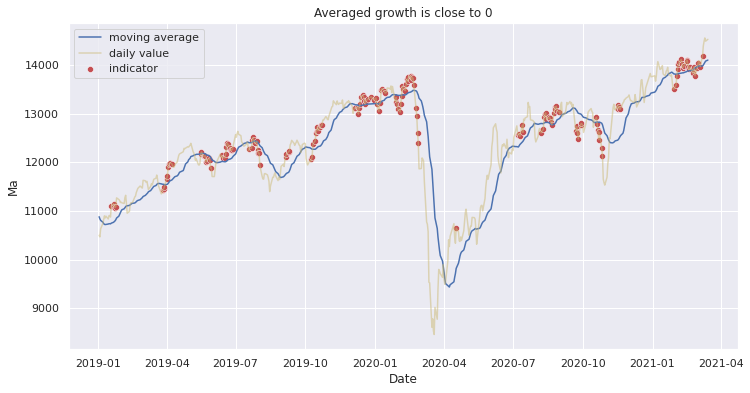

In [194]:
# Visualization of this indicator.
fig, ax = plt.subplots(1,1,figsize=(12,6))
plt.title("Averaged growth is close to 0")
sns.lineplot(data = df_new_2019.Ma, ax=ax, color="b", label = 'moving average')
sns.lineplot(data = df_new_2019.Daily,alpha=0.5, ax=ax, color="y", label = 'daily value')
sns.scatterplot(data = B.Daily, color="r", ax=ax, label = 'indicator')

### Combination of the above two indicators

In [195]:
#Applying one after the other transformation.
pipe = Pipeline([("boll_up", BollUp()),("grow_stop",LocalE(eps=100))])
B = pipe.fit_transform(df_new_2019)

<AxesSubplot:title={'center':'Combined indicators'}, xlabel='Date', ylabel='Daily'>

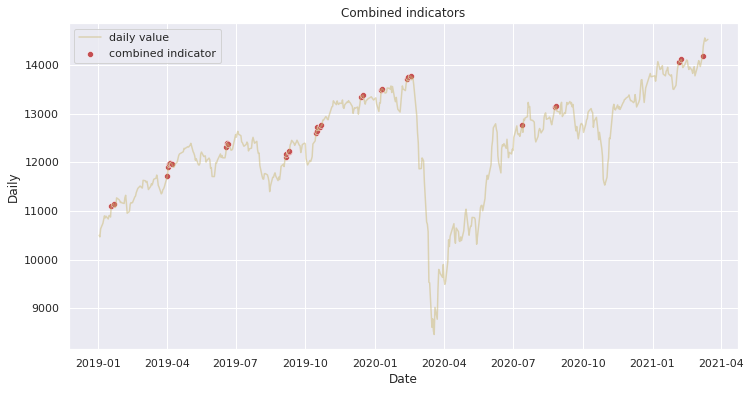

In [196]:
# Visualization of combined indicators.
fig, ax = plt.subplots(1,1,figsize=(12,6))
plt.title("Combined indicators")
sns.lineplot(data = df_new_2019.Daily,alpha=0.5, ax=ax, color="y", label = 'daily value')
sns.scatterplot(data = B.Daily, color="r", ax=ax, label = 'combined indicator')

These indicators seem quite pessimistic on this example. However, we remark that they strongly depend 
on the choice of the parameters N, K, M and eps. In the following we try to tune these on some time interval and later we use the tuned parameters in the following period of time.

## 3. Scores <a id="scores"></a>

In order to compare out investment strategies we will define a score function. In particular, the score is computed as follows:

<ul>
<li>We fix a time window in which we employ the considered strategy. Reminder: We are given 1 cash unit each month for investment. </li>
<li> In the very last day of the time window we compute the total gains which defines the score of the strategy. </li>
</ul>

The parameter tuning will be also based on this score.


In [197]:
# Calculation of the number of months between two dates:
def nr_months(date1, date2): 
    return (date2.year - date1.year) * 12 - date1.month + date2.month

# Computes how much we invest at each indicator:
def invest(DF, start_invest, end_invest): #the input DF contains only the given investment indicators.
    DF_new = DF.loc[start_invest:end_invest,:].copy()
    investment = np.zeros(len(DF_new))
    investment[0] = nr_months(start_invest, DF_new.index[0])
    for i in range(1,len(DF_new)):
        investment[i] = nr_months(DF_new.index[i-1],DF_new.index[i])
    DF_new["Invest"] = investment #the new column tells the number of cash units invested at a given date
    return DF_new

#Computes the rendite if we buy at date1 and sell at date2 
def rendite(DF, date1, date2):
    d1 = DF.loc[date1, "Daily"]
    d2 = DF.loc[date2, "Daily"]
    return  (d2 - d1)/ d1

#Computes rendite and gain for each investment compared with the realization date:
def gain(DF, DF_old, date_real): # date_real is the realization date = last day of investment period
    DF_new = DF[DF["Invest"]>0].copy()
    rend = pd.Series(np.zeros(len(DF_new)), index=DF_new.index) 
    for i in DF_new.index:
        rend[i] = rendite(DF_old, i, date_real)
    DF_new["Rendite"] = rend
    DF_new["Rendite %"] = rend * 100
    DF_new["Gain"] = DF_new.Invest * DF_new.Rendite
    return DF_new

The score for the strategy is given by "DF_new.Gain.sum()"

In [198]:
# The score of the above example in the period 2019-today
start_invest = dt.datetime(2018,12,31)
end_invest = df_new_2019.index[len(df_new_2019)-1]

C = B.copy()
a = pd.DataFrame(df_new_2019.iloc[len(df_new_2019)-1,:]).copy().T
C = C.append(a) #we add an artificial indicator on the last day that represents the cash reserve
C_invest = invest(C, start_invest, end_invest)
C_final = gain(C_invest, df_new_2019, end_invest)
C_final

,Daily,Ma,Std,BollingerLow,BollingerHigh,Growth,GrowthSum,Invest,Rendite,Rendite %,Gain
2019-01-18,11105.325195,10749.922241,178.431605,10482.274833,11017.569649,14.337769,-57.026050,1.0,0.308083,30.808326,0.308083
2019-04-02,11718.400391,11549.953271,110.510252,11384.187894,11715.718649,6.439258,4.707983,3.0,0.239648,23.964786,0.718944
2019-06-19,12318.945312,12023.247290,153.648971,11792.773833,12253.720747,9.818506,18.146802,2.0,0.179215,17.921539,0.358431
2019-09-05,12117.739746,11751.482031,171.777332,11493.816033,12009.148030,17.651978,-89.559473,3.0,0.198795,19.879534,0.596386
2019-10-15,12597.150391,12278.336084,178.079134,12011.217383,12545.454785,10.251758,-11.858911,1.0,0.153173,15.317270,0.153173
2019-12-13,13339.479980,13166.985254,90.067494,13031.884012,13302.086496,6.108765,-35.658740,2.0,0.089000,8.899972,0.177999
2020-01-09,13490.060059,13237.317236,120.972290,13055.858801,13418.775672,18.417017,48.645996,1.0,0.076844,7.684398,0.076844
2020-02-12,13708.425293,13408.681299,182.729746,13134.586679,13682.775919,14.236499,20.532495,1.0,0.059691,5.969064,0.059691
2020-07-13,12762.675293,12413.347754,189.192307,12129.559293,12697.136214,48.986768,97.054224,5.0,0.138217,13.821668,0.691083
2020-08-25,13141.345215,12794.199463,194.001956,12503.196530,13085.202396,15.005518,-14.949561,1.0,0.105419,10.541879,0.105419


In [199]:
print(f"The score is {C_final.Gain.sum()} with rendite {C_final.Gain.sum()/C_final.Invest.sum() *100}%")

The score is 3.4672660634351593 with rendite 12.841726160870962%


<AxesSubplot:title={'center':'Investment strategy based on indicators'}, xlabel='Date', ylabel='Daily'>

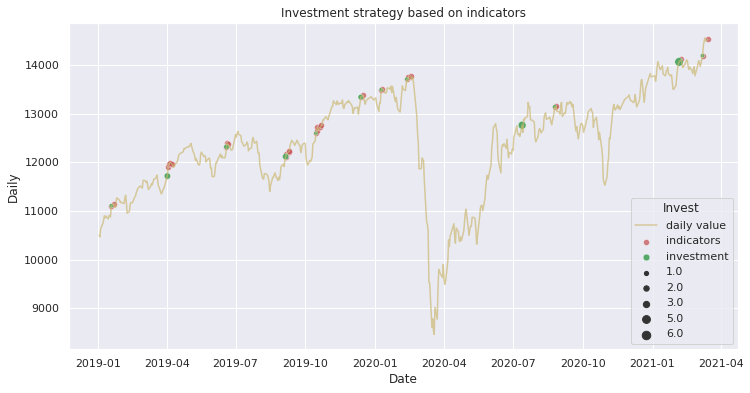

In [200]:
#Visualization
fig, ax = plt.subplots(1,1,figsize=(12,6))
plt.title("Investment strategy based on indicators")
sns.lineplot(data = df_new_2019.Daily, ax=ax, color="y", alpha=0.7, label = 'daily value')
sns.scatterplot(data = C,
                x=C.index, y=C.Daily, 
                 color="r", ax=ax, alpha=0.7, label = 'indicators')
sns.scatterplot(data = C_final,
                x=C_final.index, y=C_final.Daily, 
                size= C_final.Invest, color="g", ax=ax, label = 'investment')

## 4. Strategies <a id="strat"></a>

We consider the following strategies:

### Bollinger+
The considered indicators are only points above the Bollinger band. As long as an indicator appears we invest all our available cash. Parameters: N and K. We choose the parameters based on the data in time 2015-2018. In particular, in this period we make a simple grid search to find the largest score. The obtained optimal parameters are used for the comparison with the rest of the strategies in the time 2019-today.

### Bollinger+Min
The considered indicators are points above the Bollinger band and such that the sum of growth (GrowthSum) is in the interval (-eps,eps). As long as an indicator appears we invest all our available cash. Parameters: N, K, M and eps. We choose the parameters based on the data in the time 2015-2018. In particular, in this period we make a simple grid search to find the largest score. The obtained optimal parameters are used for the comparison with the rest of the strategies in the time 2019-today.


### Sparplan
Each first day of a month we invest 1 cash unit.


## 5. Parameter tuning and computation of scores<a id="tuning"></a>
In the following we tune the parameters for the first two strategies and compute the scores for all of them. The parameter tuning period is 2015-2018 and the test period is 2019-today.

In [201]:
#The comparison of the strategies will be done on the following stock indices in the time period 2019-today:
Indices = {"^GSPC":"S&P 500", "^DJI":"Dow Jones Industrial Average", "^IXIC":"NASDAQ Composite",
          "^GDAXI":"DAX", "^TECDAX":"TECDAX", "^N225":"Nikkei 225", "^NSEI":"NIFTY 50", "^KS11":"KOSPI Composite Index",
           "IMOEX.ME":"MOEX Russia Index", "^FCHI":"CAC 40"}

In [202]:
#Parameter ranges for parameter tuning:
ran_N = [2, 5, 10, 15, 20, 25, 30, 40, 50, 60] #range for parameter N
ran_K = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2] #range for parameter K
ran_M = ran_N #, 40, 50, 60, 70] #range for parameter M
ran_eps = [1, 2, 10, 15, 20, 100] #range for parameter eps - this parameter has to be chosen 
#carefully since it depends on the actual values of the stock or index

print(f"Number of nodes for grid search: {len(ran_N)*len(ran_K)*len(ran_M)*len(ran_eps)}")

Number of nodes for grid search: 4800


In [203]:
t1 = dt.datetime.now()
# We save the scores in these dictionaries:
# the index of each dictionary is the symbol of the corresponding stock index
# the value corresponding to the index is a dataframe containing the information about investment days and gains


#Bollinger+
results_b = {}

#Bollinger+Min
results_bm = {}

#Sparplan
results_s = {}

#Optimal parameters
parameters = {}

# We run through all the stock indices and compute their scores (for first two we also do parameter tuning)
for i in Indices:
    #LOADING DATA
    symb = i # Symbol. 
#     print(i)
    name = Indices[i]    # Name of index.
    start = dt.datetime(2014,1,1)
    end = dt.date.today()
    df = dr.DataReader(symb,'yahoo', start, end) 
    
    #PARAMETER TUNING BOLL+ AND BOLL+MIN
    start_invest = dt.datetime(2014,12,31) 
    end_invest = dt.datetime(2018,12,31) #tuning interval
    DF = df.loc[start_invest:end_invest, :].copy()
    dailyclean = DailyClean()
    DF_clean = dailyclean.fit_transform(DF) #cleaning data
    
    #Bollinger+
    score_opt = -1000000 #contains best score for Bollinger+ strategy
    parameters_opt = [1, 1] #contains optimal parameters for Bollinger+ strategy
#     print("Boll+")
    for N,K in product(ran_N, ran_K):
        mastd = MaStd(N=N, K=K, M=5)
        DF_new = mastd.fit_transform(DF_clean) #computation of new features.
        bollup = BollUp()
        DF_ind = bollup.fit_transform(DF_new) #computation of indicators.
        a = pd.DataFrame(DF_new.iloc[len(DF_new)-1,:]).copy().T
        DF_ind = DF_ind.append(a) #we add an artificial indicator on the last day= cash reserve
        DF_invest = invest(DF_ind, start_invest, end_invest) #computes the days where we invest.
        DF_final = gain(DF_invest, DF_new, DF_new.index[len(DF_new)-1]) #computes rendite and gain.
#         print(f"Investment {DF_final.Invest.sum()}, gain {DF_final.Gain.sum()},rendite {DF_final.Gain.sum()/DF_final.Invest.sum() *100}%")
        score_cur = DF_final.Gain.sum() #total gain is the score
        if score_cur > score_opt:
            score_opt = score_cur # updates maximal score if necessary
            parameters_opt = [N, K]
    par_b = parameters_opt #optimal parameters for Bollinger+
    
    #Bollinger+Min
    score_opt = -1000000 #contains best score for Bollinger+ strategy
    parameters_opt = [1, 1, 1, 1] #contains optimal parameters for Bollinger+ strategy
#     print("Boll+Min")
    for N,K,M,eps in product(ran_N, ran_K, ran_M, ran_eps):
        mastd = MaStd(N=N, K=K, M=M)
        DF_new = mastd.fit_transform(DF_clean) #computation of new features.
        pipe = Pipeline([("boll_up", BollUp()),("grow_stop",LocalE(eps=eps))])
        DF_ind = pipe.fit_transform(DF_new) #computation of indicators. #computation of indicators.
        a = pd.DataFrame(DF_new.iloc[len(DF_new)-1,:]).copy().T
        DF_ind = DF_ind.append(a) #we add an artificial indicator on the last day= cash reserve
        DF_invest = invest(DF_ind, start_invest, end_invest) #computes the days where we invest.
        DF_final = gain(DF_invest, DF_new, DF_new.index[len(DF_new)-1]) #computes rendite and gain.
#         print(f"Investment {DF_final.Invest.sum()}, gain {DF_final.Gain.sum()},rendite {DF_final.Gain.sum()/DF_final.Invest.sum() *100}%")
        score_cur = DF_final.Gain.sum() #total gain is the score
        if score_cur > score_opt:
            score_opt = score_cur # updates maximal score if necessary
            parameters_opt = [N, K, M, eps]
    par_bm = parameters_opt #optimal parameters for Bollinger+Min

    parameters[symb] = [par_b, par_bm]
    
    #INVESTMENT RESULTS Bollinger+
    start_invest = dt.datetime(2018,12,31) 
    end_invest = dt.date.today() #test interval
    DF = df.loc[start_invest:end_invest, :].copy()
    dailyclean = DailyClean()
    DF_clean = dailyclean.fit_transform(DF) #cleaning data
    N = par_b[0]
    K = par_b[1]
    mastd = MaStd(N=N, K=K, M=5)
    DF_new = mastd.fit_transform(DF_clean) #computation of new features.
    bollup = BollUp()
    DF_ind = bollup.fit_transform(DF_new) #computation of indicators.
    a = pd.DataFrame(DF_new.iloc[len(DF_new)-1,:]).copy().T
    DF_ind = DF_ind.append(a) #we add an artificial indicator on the last day= cash reserve
    DF_invest = invest(DF_ind, start_invest, end_invest) #computes the days where we invest.
    DF_final = gain(DF_invest, DF_new, DF_new.index[len(DF_new)-1]) #computes rendite and gain.
    
    results_b[symb] = DF_final
    
    #INVESTMENT RESULTS BOLLINGER+MIN
    N = par_bm[0]
    K = par_bm[1]
    M = par_bm[2]
    eps = par_bm[3]
    mastd = MaStd(N=N, K=K, M=M)
    DF_new = mastd.fit_transform(DF_clean) #computation of new features.
    pipe = Pipeline([("boll_up", BollUp()),("grow_stop",LocalE(eps=eps))])
    DF_ind = pipe.fit_transform(DF_new) #computation of indicators. #computation of indicators.
    a = pd.DataFrame(DF_new.iloc[len(DF_new)-1,:]).copy().T
    DF_ind = DF_ind.append(a) #we add an artificial indicator on the last day= cash reserve
    DF_invest = invest(DF_ind, start_invest, end_invest) #computes the days where we invest.
    DF_final = gain(DF_invest, DF_new, DF_new.index[len(DF_new)-1])
    
    results_bm[symb] = DF_final

    #INVESTMENT RESULTS SPARPLAN
    DF_ind = DF_clean.copy() #indicators are all days
    DF_invest = invest(DF_ind, start_invest, end_invest) #this invests 1 cash unit on the first working day of a 
#month.
    DF_final = gain(DF_invest, DF_clean, DF_clean.index[len(DF_clean)-1])
    
    results_s[symb] = DF_final
    
t2 = dt.datetime.now()

In [209]:
print(f"For reference: This computation takes {t2-t1} on a 6 years old notebook.") 

For reference: This computation takes 1:19:51.807934 on a 6 years old notebook.


## 6. Evaluation of results <a id="eval"></a>

In [210]:
print(f"We compare the scores of the strategies Bollinger+, Bollinger+Min and Sparplan in the time interval 2019-today.")
print("We consider the following stock indices for our comparison:")
for i in Indices:
    print(Indices[i])

We compare the scores of the strategies Bollinger+, Bollinger+Min and Sparplan in the time interval 2019-today.
We consider the following stock indices for our comparison:
S&P 500
Dow Jones Industrial Average
NASDAQ Composite
DAX
TECDAX
Nikkei 225
NIFTY 50
KOSPI Composite Index
MOEX Russia Index
CAC 40


In [216]:
DR = pd.Series(Indices)
DR = pd.DataFrame(DR) 
for i in Indices:
#     DR.loc[i, "Invest(B+)"] = results_b[i].Invest.sum()
#     DR.loc[i, "Invest(B+M)"] = results_bm[i].Invest.sum()
#     DR.loc[i, "Invest(S)"] = results_s[i].Invest.sum()
    DR.loc[i, "Gain(B+)"] = results_b[i].Gain.sum()
    DR.loc[i, "Gain(B+M)"] = results_bm[i].Gain.sum()
    DR.loc[i, "Gain(S)"] = results_s[i].Gain.sum()
    DR.loc[i, "Rendite%(B+)"] = results_b[i].Gain.sum() / results_b[i].Invest.sum() * 100
    DR.loc[i, "Rendite%(B+M)"] = results_bm[i].Gain.sum() / results_bm[i].Invest.sum() * 100
    DR.loc[i, "Rendite%(S)"] = results_s[i].Gain.sum() / results_s[i].Invest.sum() * 100
    DR.loc[i, "N(B+)"] = parameters[i][0][0] 
    DR.loc[i, "K(B+)"] = parameters[i][0][1]
    DR.loc[i, "N(B+M)"] = parameters[i][1][0]
    DR.loc[i, "K(B+M)"] = parameters[i][1][1]
    DR.loc[i, "M(B+M)"] = parameters[i][1][2]
    DR.loc[i, "eps(B+M)"] = parameters[i][1][3]
    
DR = DR.reset_index().rename(columns={"index":"Symbol",0:"Name"})

In the following tables we use the following shorthands:

B+ = features of Bollinger+ strategy

B+M = features of Bollinger+Min strategy

S = features of Sparplan strategy

Invest = amount of invested units in the test period (=2019-today)

Gain = total gain on the very last day of the test period (today)

Rendite% = rendite of total investment in percent

N, K, M, eps = optimized parameters chosen in the previous period (=2015-2018)

In [217]:
DR

,Symbol,Name,Gain(B+),Gain(B+M),Gain(S),Rendite%(B+),Rendite%(B+M),Rendite%(S),N(B+),K(B+),N(B+M),K(B+M),M(B+M),eps(B+M)
0,^GSPC,S&P 500,7.073934,5.119578,7.531785,26.199757,18.961401,27.895500,20.0,1.50,25.0,1.50,2.0,1.0
1,^DJI,Dow Jones Industrial Average,5.386968,2.040558,6.056630,19.951733,7.557622,22.431962,25.0,1.50,25.0,0.75,2.0,2.0
2,^IXIC,NASDAQ Composite,12.756592,6.520731,12.846893,47.246636,24.150856,47.581085,2.0,0.25,10.0,1.50,25.0,15.0
3,^GDAXI,DAX,0.000000,2.996918,5.195412,0.000000,11.099698,19.242266,2.0,0.75,2.0,0.25,60.0,1.0
4,^TECDAX,TECDAX,3.816859,2.535197,4.035916,14.136516,9.389618,14.947835,5.0,0.50,20.0,0.25,5.0,1.0
5,^N225,Nikkei 225,8.948096,3.925235,8.969569,33.141098,14.537909,33.220627,2.0,0.25,2.0,0.25,50.0,10.0
6,^NSEI,NIFTY 50,8.057107,8.146279,8.337142,29.841137,30.171403,30.878305,5.0,1.00,2.0,0.25,10.0,10.0
7,^KS11,KOSPI Composite Index,0.000000,4.684071,10.623736,0.000000,17.348412,39.347170,2.0,0.75,20.0,0.75,20.0,1.0
8,IMOEX.ME,MOEX Russia Index,7.391478,6.988973,7.495922,27.375845,25.885085,27.762673,5.0,0.25,5.0,0.50,50.0,100.0
9,^FCHI,CAC 40,0.000000,3.892179,4.395531,0.000000,14.415477,16.279744,2.0,0.75,5.0,0.25,40.0,2.0


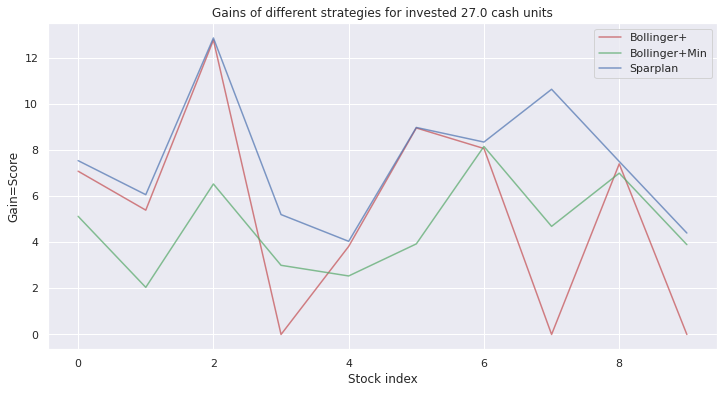

In [218]:
# Visualization of scores

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.set_xlabel("Stock index")
ax.set_ylabel("Gain=Score")
plt.title(f"Gains of different strategies for invested {results_b[i].Invest.sum()} cash units")
sns.lineplot(data = DR["Gain(B+)"], ax=ax, color="r", alpha=0.7, label="Bollinger+")
sns.lineplot(data = DR["Gain(B+M)"], ax=ax, color="g", alpha=0.7, label="Bollinger+Min")
sns.lineplot(data = DR["Gain(S)"], ax=ax, color="b", alpha=0.7, label="Sparplan")
plt.legend()

# Conclusion
The monthly investment strategy Sparplan is dominant for all of the considered stock indices in comparison with the parameter based Bollinger+ and Bollinger+M. We remark that this comparison is done in the time interval 2019-today and it is based on an "only buy" strategy. The choice of the parameters for the parameter based strategies seems to be quite heterogeneous considering different stock markets. This might suggest that a better tuning mechanism may improve the scores of these strategies.

# Outlook
<ul>
<li> With minor changes in this notebook other standard investment strategies may be tested against the Sparplan strategy. </li>
<li>Finer parameter tuning and ensemble type scoring for the choice of parameters can be considered to improve the parameter based strategies.</li>
<li> We may include "selling" into the strategy. In this way for example shorting may improve the score of the parameter based strategies.</li>
</ul>